# Sobre

### Nosso objetivo é criar um modelo de Machine Learning Simples utilizando Scikit-Learning que tenta “adivinhar” a nota dos candidatos em matemática (NU_NOTA_MT).


- Como variável de entrada, utilizaremos as colunas do questionário sócio econômico, acrescridas de cor/raça, tipo de escola, estado da prova e estado civil. Ou seja, utilize as colunas:  
NU_ANO, Q001, Q002, Q003, Q004, Q005, Q006, Q007, Q008, Q009, Q010, Q011, Q012, Q013, Q014, Q015, Q016, Q017, Q018, Q019, Q020, Q021, Q022, Q023, Q024, Q025, Q026, Q027, TP_ESTADO_CIVIL, TP_COR_RACA, TP_ESCOLA, CO_UF_PROVA.

- Random Forest só irá aceitar entradas numéricas.
  - Como existem colunas textuais, precisamos transformá-las em categóricas numéricas *
- Devido diferença de colunas, vamos usar o ano como uma coluna de entrada *
- Considere apenas alunos que fizeram a prova de matemática (TP_PRESENCA_MT=1)  

- Missing Values (alternativas?):
  - Caso o campo não esteja preenchido, preencher com zero.
  - Alternativa: Como temos uma grande quantidade de dados, podemos considerar apenas os alunos que possuem todos os campos necessários preenchidos (Not Null)

- Treino e Teste (devem ser determinísticos)
  - Colocar 80% dos dados em uma tabela chamada enem.ml_treino em teu dataset
  - Colocar 20% dos dados em uma tabela chamada enem. ml_teste em teu dataset

---
Pesquisar comandos úteis como:  
CASE .. WHEN .. END, MOD, CONCAT, ML.LABEL_ENCODER,
RAND, farm_fingerprint, GENERATE_UUID


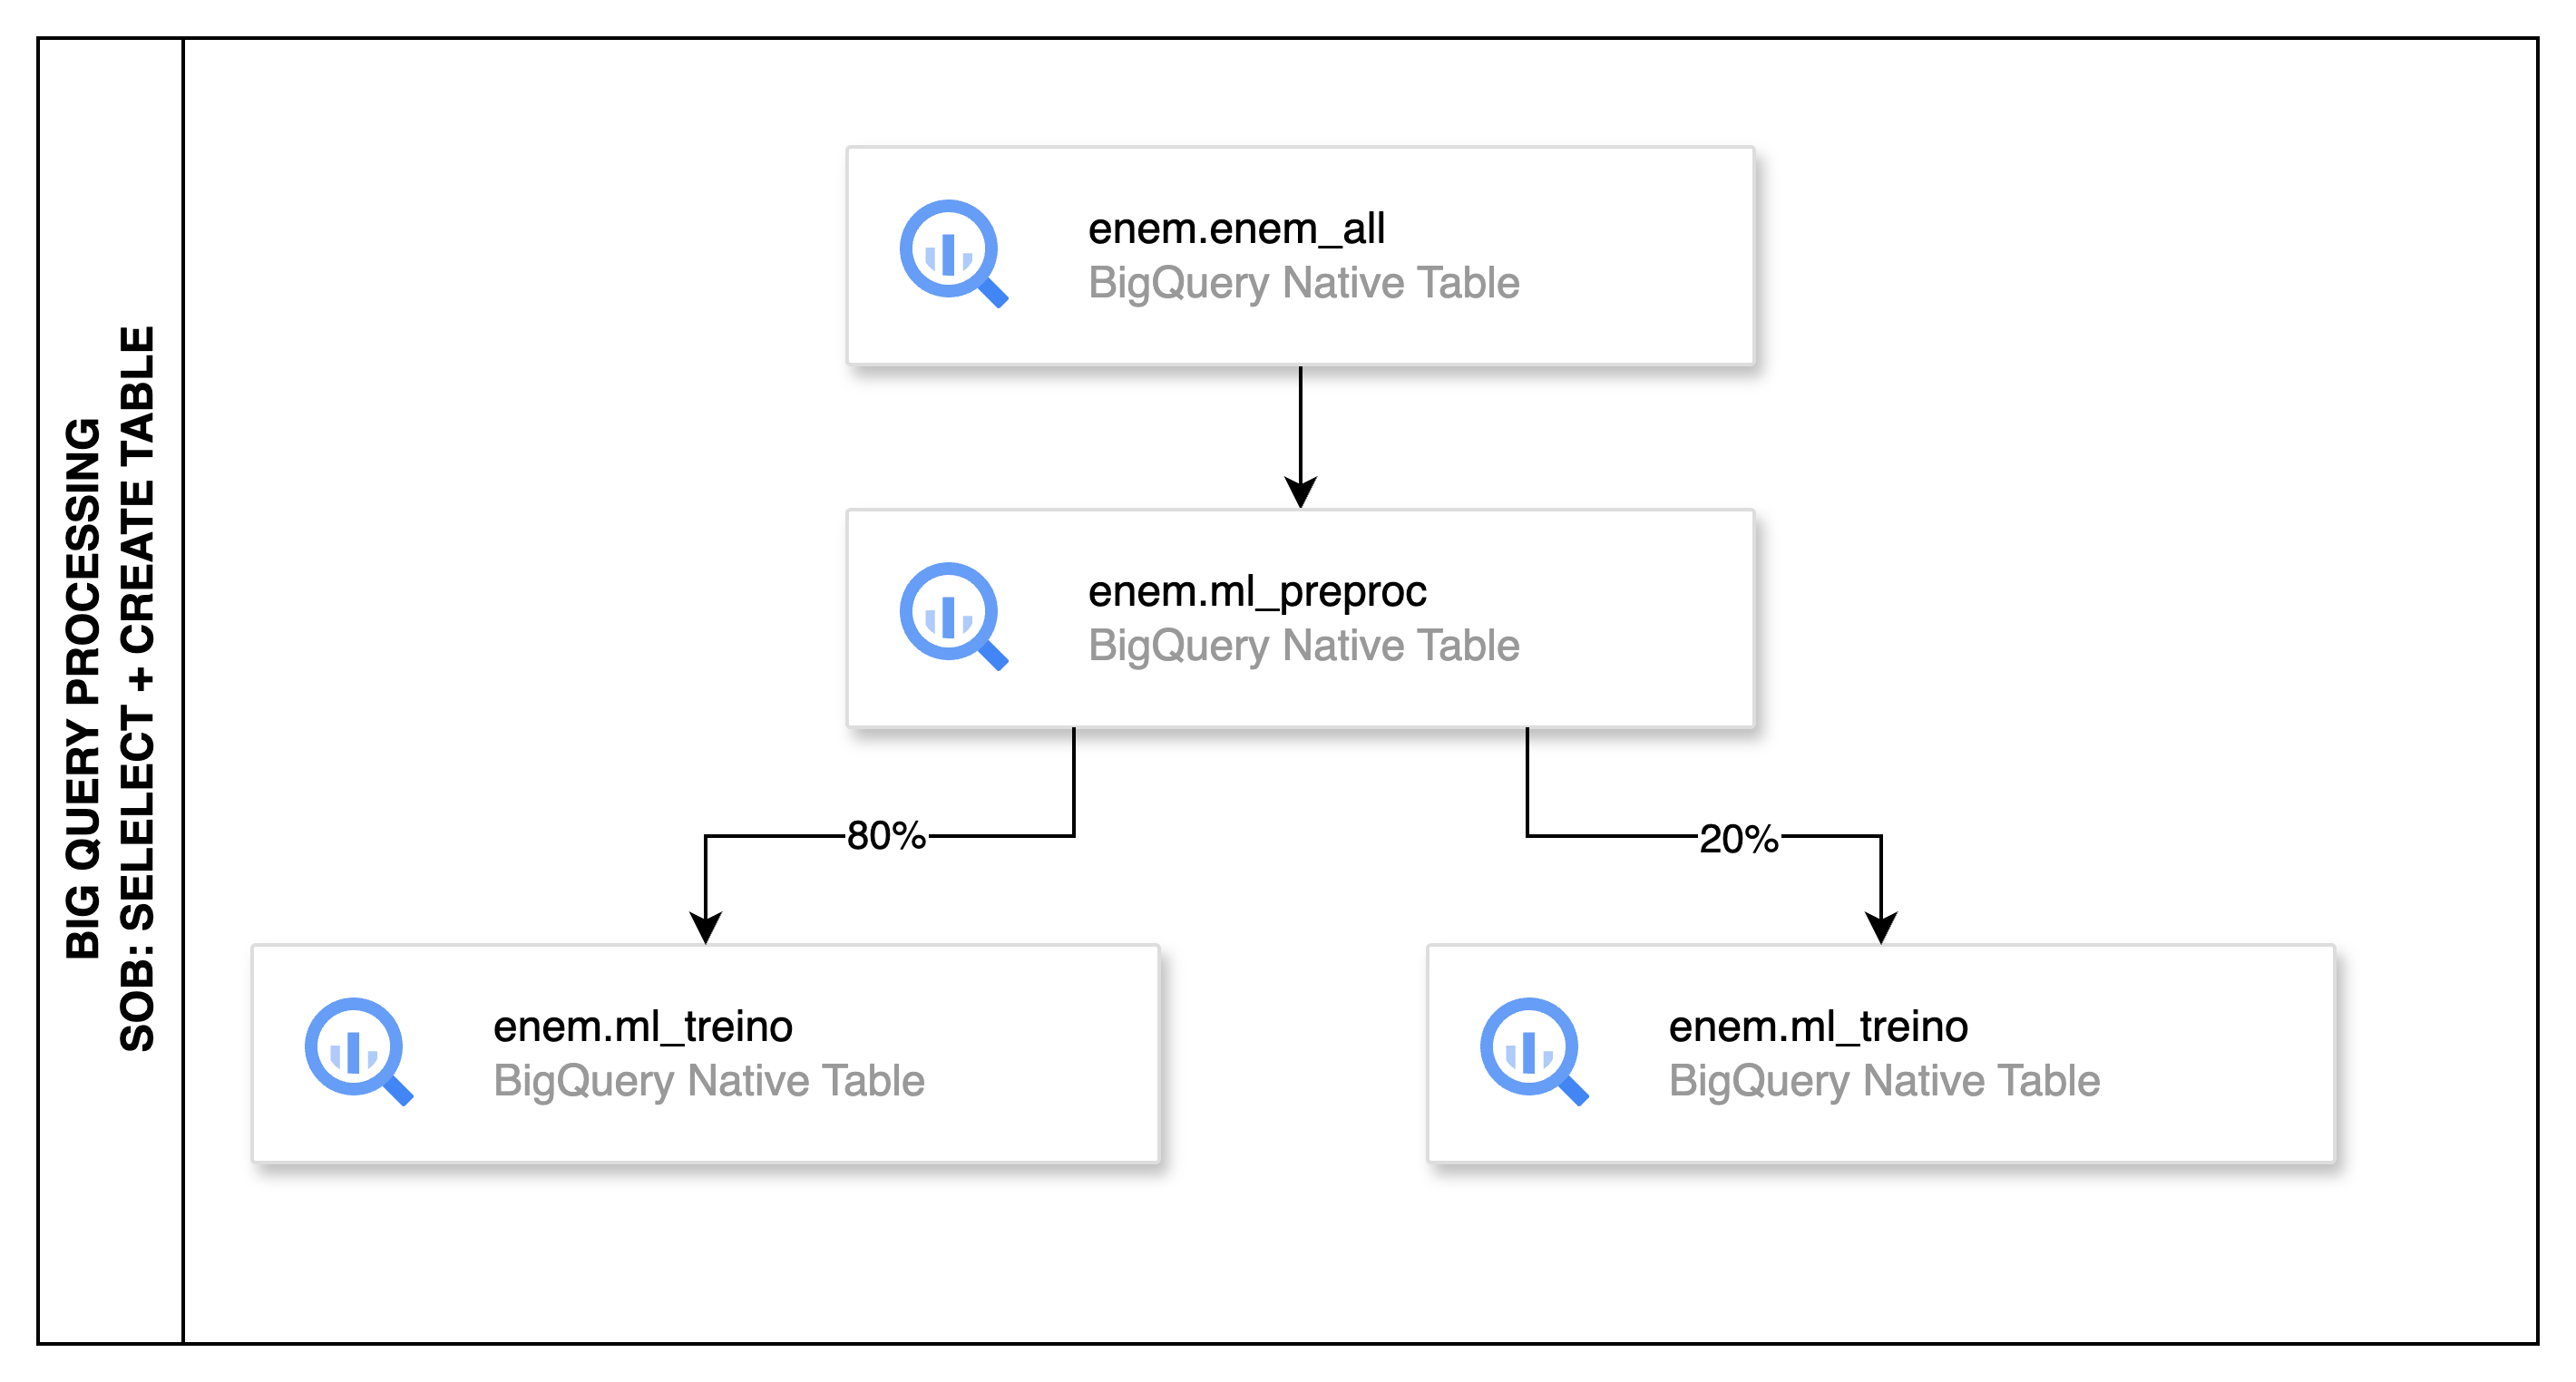

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import urllib.request

from google.cloud import bigquery
from google.oauth2 import service_account

# Autenticação do Colab com o Bigquery

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
#@title Preenchimento do código do projeto
#@markdown Preencha abaixo o código do teu projeto na GCP. <br/>
#@markdown Após preenchimento do código, execute essa célula.   <br/>

project_id = "dynamic-camp-468900-t5"  #@param {type: "string"}
#@markdown ---
clientbq = bigquery.Client(project=project_id)


A célula a seguir testa a conexão do Big Query, listando todos os datasets disponíveis.

In [4]:
for dataset in clientbq.list_datasets():
  print(dataset.dataset_id)

enem


# Geração de Tabela com Feature Engineering





## Dados de Treinamento Pré Processados


Use a célula a seguir para colocar os seus comandos de pré-processamento

In [5]:
%%time
query_sql = f"""
CREATE OR REPLACE TABLE enem.base_completa AS
SELECT
  farm_fingerprint(GENERATE_UUID()) AS HASHID,
  t.NU_ANO,
  t.TP_PRESENCA_MT,
  t.NU_NOTA_MT,
  t.Q001, t.Q002, t.Q003, t.Q004, t.Q005, t.Q006, t.Q007, t.Q008, t.Q009, t.Q010,
  t.Q011, t.Q012, t.Q013, t.Q014, t.Q015, t.Q016, t.Q017, t.Q018, t.Q019, t.Q020,
  t.Q021, t.Q022, t.Q023, t.Q024, t.Q025, t.Q026, t.Q027,
  t.TP_ESTADO_CIVIL, t.TP_COR_RACA, t.TP_ESCOLA, t.CO_UF_PROVA,
  CAST(NULL AS INT64) AS IN_TEMPO_ADICIONAL,
  CAST(NULL AS INT64) AS TP_FAIXA_ETARIA
FROM `dynamic-camp-468900-t5.enem.enem_2018` AS t
WHERE t.TP_PRESENCA_MT = 1 AND t.NU_NOTA_MT IS NOT NULL
"""
query_job = clientbq.query(query_sql)  # Make an API request.
query_job.result()

CPU times: user 22.5 ms, sys: 1.28 ms, total: 23.8 ms
Wall time: 25.1 s


# Split treino (80%) e teste (20%)

In [6]:
%%time
query_sql = f"""
CREATE OR REPLACE TABLE `dynamic-camp-468900-t5.enem.ml_treino` AS
SELECT
  t.*
FROM `dynamic-camp-468900-t5.enem.enem_2018` AS t
WHERE
  t.TP_PRESENCA_MT = 1
  AND MOD(ABS(FARM_FINGERPRINT(CAST(t.NU_INSCRICAO AS STRING))), 10) < 8;

"""
query_job = clientbq.query(query_sql)  # Make an API request.
query_job.result()

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 27.4 s


In [7]:
%%time
query_sql = f"""
CREATE OR REPLACE TABLE `dynamic-camp-468900-t5.enem.ml_teste` AS
SELECT
  t.*
FROM `dynamic-camp-468900-t5.enem.enem_2018` AS t
WHERE
  t.TP_PRESENCA_MT = 1
  AND MOD(ABS(FARM_FINGERPRINT(CAST(t.NU_INSCRICAO AS STRING))), 10) >= 8;

"""
query_job = clientbq.query(query_sql)  # Make an API request.
query_job.result()

CPU times: user 21.3 ms, sys: 2.1 ms, total: 23.4 ms
Wall time: 30.9 s


Teste com busca dos dados gerados

In [8]:
%%time
query_sql = f"""
  SELECT *
  FROM enem.ml_treino
  LIMIT 100
"""
query_job = clientbq.query(query_sql)  # Make an API request.
enem_dados = query_job.to_dataframe()
display(enem_dados)

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180012620312,2018,1100015,Alta Floresta D'Oeste,11,RO,19,F,0,3,...,A,A,A,A,D,A,B,B,A,A
1,180011030871,2018,1100015,Alta Floresta D'Oeste,11,RO,19,F,0,3,...,A,B,B,A,C,A,B,B,A,A
2,180012122612,2018,1100023,Ariquemes,11,RO,21,F,0,5,...,A,C,B,A,D,A,A,A,A,A
3,180008657039,2018,1100023,Ariquemes,11,RO,19,M,0,3,...,A,B,A,A,C,B,B,B,A,A
4,180013153931,2018,1100023,Ariquemes,11,RO,21,M,0,3,...,A,B,A,A,C,A,B,B,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,180012962821,2018,1100205,Porto Velho,11,RO,21,F,0,3,...,A,B,A,A,D,B,B,B,A,A
96,180012376968,2018,1100205,Porto Velho,11,RO,20,M,0,3,...,A,B,A,A,E,B,B,B,A,A
97,180007212917,2018,1100205,Porto Velho,11,RO,21,F,0,3,...,A,B,A,A,C,A,B,A,A,A
98,180010925891,2018,1100205,Porto Velho,11,RO,26,M,0,3,...,A,B,A,A,D,A,B,B,A,A


CPU times: user 104 ms, sys: 20.3 ms, total: 124 ms
Wall time: 2.6 s


In [9]:
%%time
query_sql = f"""
  SELECT *
  FROM enem.ml_teste
  LIMIT 100
"""
query_job = clientbq.query(query_sql)  # Make an API request.
enem_dados = query_job.to_dataframe()
display(enem_dados)

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180008352652,2018,3303401,Nova Friburgo,33,RJ,17,F,0,1,...,B,C,B,A,E,B,E,B,None,D
1,180007877148,2018,1100015,Alta Floresta D'Oeste,11,RO,36,F,1,3,...,A,B,B,A,C,A,A,A,A,A
2,180010069164,2018,1100015,Alta Floresta D'Oeste,11,RO,39,M,1,3,...,A,B,A,A,C,A,B,B,A,A
3,180009482490,2018,1100015,Alta Floresta D'Oeste,11,RO,19,M,0,5,...,A,A,A,A,A,A,A,B,A,A
4,180008697871,2018,1100015,Alta Floresta D'Oeste,11,RO,25,F,1,3,...,A,B,A,A,A,A,A,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,180012279659,2018,1100023,Ariquemes,11,RO,22,F,0,3,...,A,B,A,A,B,A,B,A,A,A
96,180013415769,2018,1100023,Ariquemes,11,RO,22,M,0,3,...,A,A,A,A,B,A,A,A,A,A
97,180009958975,2018,1100023,Ariquemes,11,RO,19,F,0,3,...,A,A,A,A,B,A,A,A,A,A
98,180011476766,2018,1100023,Ariquemes,11,RO,19,F,0,3,...,A,B,B,A,D,B,A,A,A,A


CPU times: user 46.6 ms, sys: 9.72 ms, total: 56.4 ms
Wall time: 2.5 s
